# Taylor Diagrams

## Overview

Taylor diagrams are a visual way of representing a statistical summary of how at least two datasets compare, where all plotted datasets are statistically compared to the same reference dataset (typically climate observations). Taylor diagrams are radial plots, with distance from the origin determined by a normalized standard deviation of your dataset (normalized by dividing it by the standard deviation of the reference or observational dataset) and the angle determined by the correlation coefficient between your dataset and the reference.

Taylor diagrams are popular for displaying climatological data because the normalization of variances helps account for the widely varying numerical values of geoscientific variables such as temperature or precipitation.

RMS differences and bias statistics??

This notebook explores how to create and customize Taylor diagrams using `geocat-viz`.

1. Creating a Simple Taylor Diagram
1. Plotting Different Ensemble Members
1. Displaying Distinct Datasets
1. Finishing Touches



## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |

- **Time to learn**: 50 minutes

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cftime

import geocat.viz as gv
import geocat.datafiles as gdf

## Creating a Simple Taylor Diagram

Before getting into the data computation necessary to create a Taylor diagram, let's demonstrate how to make the simplest Taylor Diagram plot. Here we are using fake data with a normalized standard deviation of 0.6 and a correlation coefficeint of 0.24.

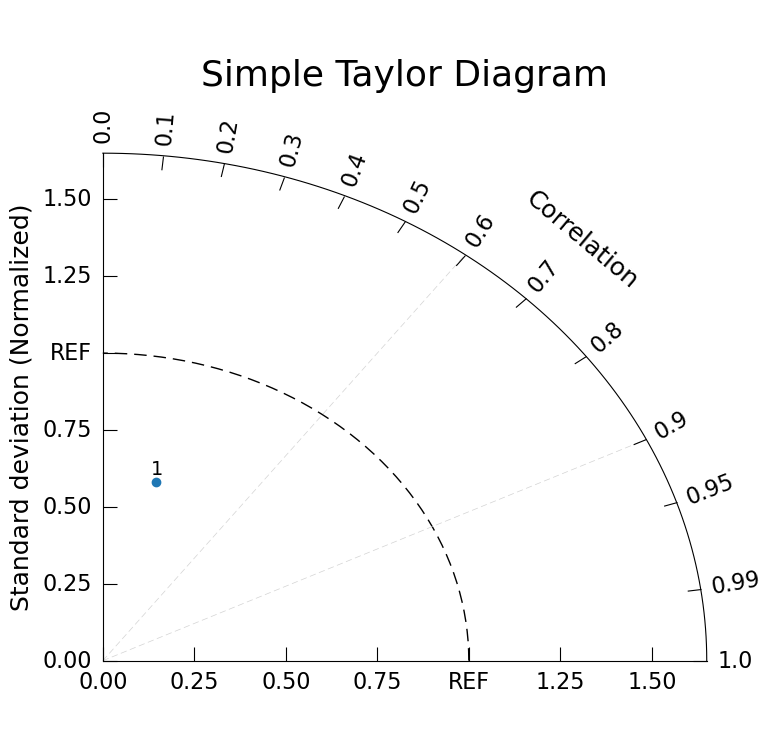

In [90]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(8, 8))
taylor = gv.TaylorDiagram(fig=fig, label='REF')

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add a model dataset of one point
taylor.add_model_set(stddev=[.6], corrcoef=[.24]);

plt.title("Simple Taylor Diagram", size=26, pad=45); # Need to move title up

## Necessary Statistical Analysis

To make understanding a Taylor Diagram more meaningful or intuitive, let's use some real data. Here we are going to use ERA5 reanalysis data as our observational dataset. CMIP5 temperature and pressure data from various representative concentration pathways (RCPs) and ensemble members as our model data.

Because these dataset can be so large, some data pre-processing has been done already to the datasets used in this example. 

 - ERA5 and CMIP5 data has been spacially averaged (removing latitudinal and longitudinal dimenstions)
 - ERA5 and CMIP5 data has been indexed to only include the year 2022
 - All ensembles from a given CMIP5 RCP model have been combined into one dataset.
 - Temperature and pressure variables from ERA5 have been combined into one dataset.


### Preparing the Reference (Observed) Dataset

Let's use geocat.datafiles to open up our ERA5 reanalysis data.

This dataset has two variables:
 - `2T_GDSO_SFC` which refers to the air temperature 2 meters above the surface, and 
 - `SP_GDSO_SFC` which is surface pressure.

For this dataset, we still need to resample our data to monthly to match the monthly CMIP5 data.

Notice that our time coordinate is in `datetime64`, we will have to manipulate either ERA5 or CMIP5 data to use the same time formatting system.

In [107]:
era5 = xr.open_dataset('../data/era5_2022_2mtemp_spres_xyav.nc')
era5

<xarray.Dataset>
Dimensions:              (initial_time0_hours: 8040)
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2022-01-01 ... ...
Data variables:
    2T_GDS0_SFC          (initial_time0_hours) float32 ...
    SP_GDS0_SFC          (initial_time0_hours) float32 ...

In [75]:
# Change hourly data to monthly
era5 = era5.rename({'initial_time0_hours': 'time'}) # Changing dimension name for convenience
era5_resampled = era5.resample(time='MS', loffset='15D').mean() #loffsest to set resampling to the center of each month as in CMIP5 data

era5_resampled

/var/folders/dd/_xm_pbpd3flgbvbnt7qhd70snnbpj_/T/ipykernel_6349/1419840240.py:3: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  era5_resampled = era5.resample(time='MS', loffset='15D').mean()


<xarray.Dataset>
Dimensions:      (time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-16 2022-02-16 ... 2022-12-16
Data variables:
    2T_GDS0_SFC  (time) float32 277.2 277.0 277.1 nan ... 279.2 277.7 277.7
    SP_GDS0_SFC  (time) float32 9.666e+04 9.664e+04 ... 9.655e+04 9.67e+04

In [108]:
era5_temp = era5_resampled['2T_GDS0_SFC'] # Because this variable name starts with a number `era5_resampled.2T_GDS0_SFC` would give an error
era5_ps = era5_resampled['SP_GDS0_SFC']

# Take a look at our final temperature data
era5_temp

<xarray.DataArray '2T_GDS0_SFC' (time: 12)>
array([277.24756, 277.00116, 277.1267 ,       nan, 279.67548, 281.2928 ,
       281.5387 , 281.20755, 280.13947, 279.15546, 277.7269 , 277.6502 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-16 2022-02-16 ... 2022-12-16
Attributes:
    long_name:  2 meter Temperature
    units:      K

### Preparing the model datasets

Here our CMIP5 data is originally sourced from the[Earth System Grid Federation](https://esgf.llnl.gov/). Let's first look at our RCP85 model, typically referred to as "business as usual."

To compare this data with the ERA5 data we need to convert our data to `datetime64`.

In [77]:
tas_rcp85 = xr.open_dataset('../data/tas_Amon_CanESM2_rcp85_2022_xyav.nc')

tas_rcp85

<xarray.Dataset>
Dimensions:  (time: 12)
Coordinates:
  * time     (time) object 2022-01-16 12:00:00 ... 2022-12-16 12:00:00
    height   float64 ...
Data variables:
    r1i1p1   (time) float32 ...
    r2i1p1   (time) float32 ...
    r3i1p1   (time) float32 ...
    r4i1p1   (time) float32 ...
    r5i1p1   (time) float32 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     ST
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-03-10T05:13:26Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    rcp:               rcp85

In [78]:
tas_rcp85['time'] = tas_rcp85.indexes['time'].to_datetimeindex()
tas_rcp85

/var/folders/dd/_xm_pbpd3flgbvbnt7qhd70snnbpj_/T/ipykernel_6349/3930724370.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp85['time'] = tas_rcp85.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:  (time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-16T12:00:00 ... 2022-12-16T12:00:00
    height   float64 ...
Data variables:
    r1i1p1   (time) float32 ...
    r2i1p1   (time) float32 ...
    r3i1p1   (time) float32 ...
    r4i1p1   (time) float32 ...
    r5i1p1   (time) float32 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     ST
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-03-10T05:13:26Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    rcp:               rcp85

### Perform the statistical calulations

We need to compute the standard deviation for both our ERA5 observed temperature data and our CMIP5 RCP85 modeled temperature, as well as the correlation coefficient between them. Then, divide the model standard deviation by the observed standard deviation to normalize it around the value 1.

In the next cell we will perform this calculation for all ensemble members.

In [102]:
temp_rcp85_std = []
temp_rcp85_corr = []

std_temp_obsv = float(era5_temp.std().values)

for em in list(tas_rcp85.data_vars): # for each ensemble member
    std = float(tas_rcp85[em].std().values)
    std_norm = std / std_temp_obsv

    corr= float(xr.corr(era5_temp, tas_rcp85[em]).values)

    temp_rcp85_std.append(std_norm)
    temp_rcp85_corr.append(corr)

## Plotting Different Ensemble Members

One application of a Taylor Diagram application is to plot the same variable from different emsembles of the same climate model.

This Taylor diagram differs from our simple example in that we've specified more keyword arguments in our `taylor.add_model_set()` call, specifying how we want our dots to be drawn. We've also added a legend of ensemble members with `taylor.add_model_name()`.

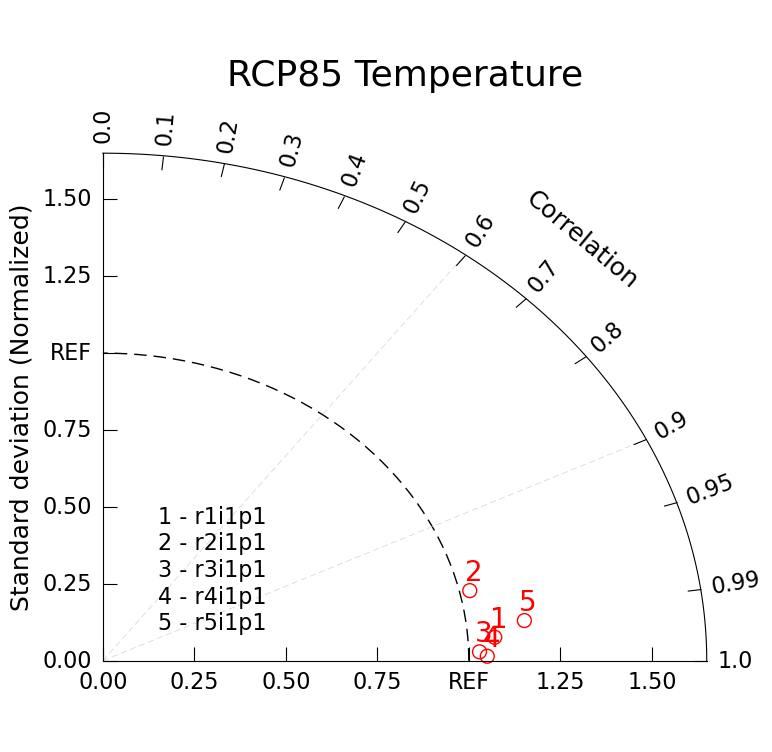

In [89]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(8, 8))
taylor = gv.TaylorDiagram(fig=fig, label='REF')
ax = plt.gca()

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add model sets for p and t datasets
taylor.add_model_set(
    temp_rcp85_std,
    temp_rcp85_corr,
    fontsize=20,
    xytext=(-5, 10),  # marker label location, in pixels
    color='red',
    marker='o',
    facecolors='none',
    s=100)  # marker size

namearr = list(ps_rcp85.data_vars)
taylor.add_model_name(namearr, fontsize=16)

# Add figure title
plt.title("RCP85 Temperature", size=26, pad=45);

## Plotting Multiple Variables

A Taylor Diagram can support multiple model sets, you simply need to call `taylor.add_model_set()` multiple times. By adding the `label` kwarg and calling `taylor.add_legend()` you can add a label distinguishing between the two sets.

Let's repeat our calclulations but for the pressure variable.

In [43]:
ps_rcp85 = xr.open_dataset('../data/ps_Amon_CanESM2_rcp85_2022_xyav.nc')
ps_rcp85['time'] = ps_rcp85.indexes['time'].to_datetimeindex()

/var/folders/dd/_xm_pbpd3flgbvbnt7qhd70snnbpj_/T/ipykernel_6349/1517796922.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ps_rcp85['time'] = ps_rcp85.indexes['time'].to_datetimeindex()


In [101]:
ps_rcp85_std = []
ps_rcp85_corr = []

std_ps_obsv = float(era5_ps.std().values)

for em in list(ps_rcp85.data_vars): # for each ensemble member
    std = float(ps_rcp85[em].std().values)
    std_norm = std / std_ps_obsv

    corr = float(xr.corr(era5_ps, ps_rcp85[em]).values)

    ps_rcp85_std.append(std)
    ps_rcp85_corr.append(corr) # This is producing negative correlations for some values which is destroying the plot

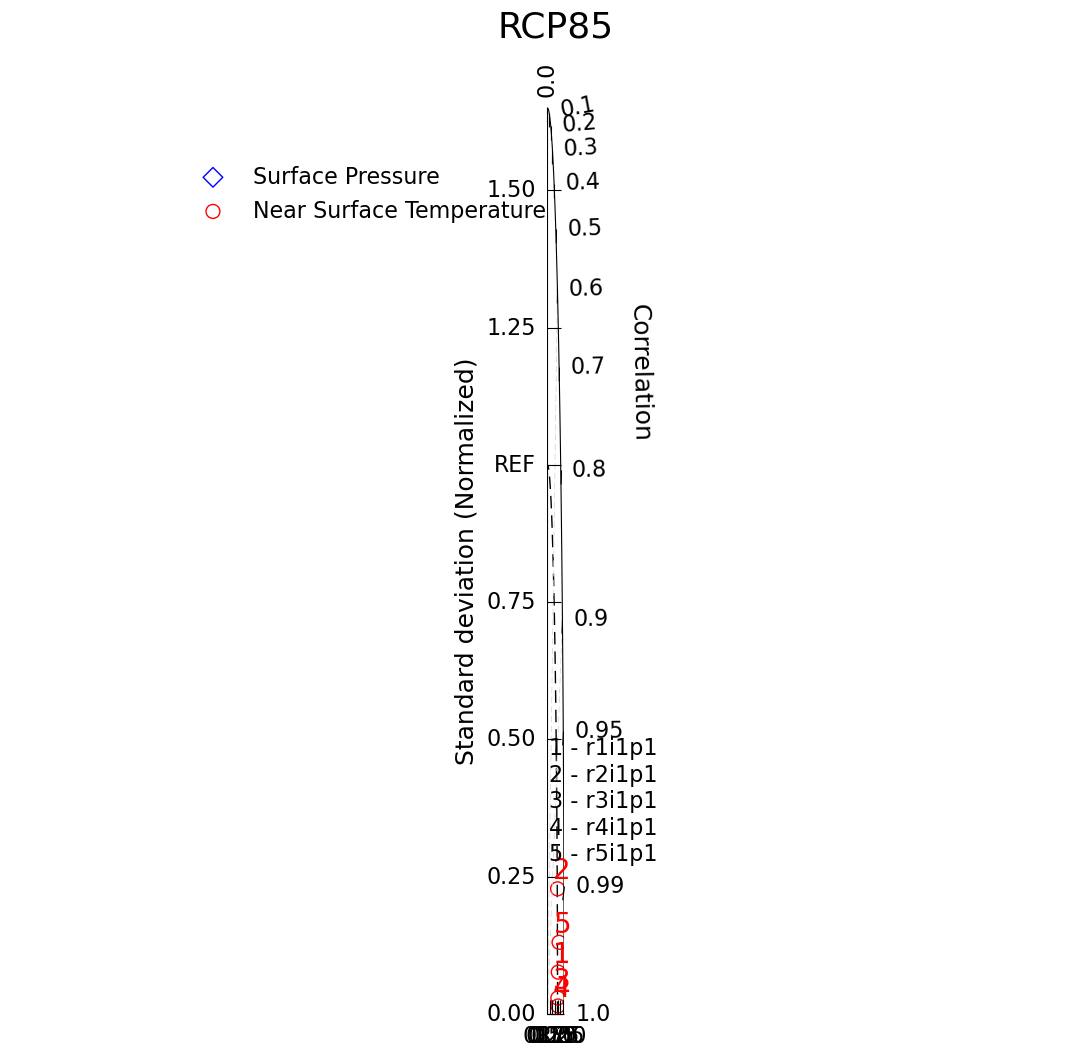

In [99]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(12, 12))
taylor = gv.TaylorDiagram(fig=fig, label='REF')
ax = plt.gca()

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add model sets for p and t datasets
taylor.add_model_set(
    temp_rcp85_std,
    temp_rcp85_corr,
    fontsize=20,
    xytext=(-5, 10),  # marker label location, in pixels
    color='red',
    marker='o',
    facecolors='none',
    label='Near Surface Temperature',
    s=100)  # marker size
taylor.add_model_set(
    ps_rcp85_std,
    ps_rcp85_corr,
    fontsize=20,
    xytext=(-5, 10),  # marker label location, in pixels
    color='blue',
    marker='D',
    facecolors='none',
    label='Surface Pressure',
    s=100)

# Add figure title
plt.title("RCP85", size=26, pad=45);

namearr = list(ps_rcp85.data_vars)
taylor.add_model_name(namearr, fontsize=16)

# Add figure legend
taylor.add_legend(fontsize=16);

## Plotting multiple models

In [100]:
tas_rcp26 = xr.open_dataset('../data/tas_Amon_CanESM2_rcp26_2022_xyav.nc')
tas_rcp26['time'] = tas_rcp26.indexes['time'].to_datetimeindex()

tas_rcp45 = xr.open_dataset('../data/tas_Amon_CanESM2_rcp45_2022_xyav.nc')
tas_rcp45['time'] = tas_rcp45.indexes['time'].to_datetimeindex()

/var/folders/dd/_xm_pbpd3flgbvbnt7qhd70snnbpj_/T/ipykernel_6349/1158326517.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp26['time'] = tas_rcp26.indexes['time'].to_datetimeindex()
/var/folders/dd/_xm_pbpd3flgbvbnt7qhd70snnbpj_/T/ipykernel_6349/1158326517.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp45['time'] = tas_rcp45.indexes['time'].to_datetimeindex()


In [103]:
temp_rcp26_std = float(tas_rcp26['r1i1p1'].std().values) 
temp_rcp26_std_norm = temp_rcp26_std / std_temp_obsv
temp_rcp26_corr = float(xr.corr(era5_temp, tas_rcp26['r1i1p1']).values)

temp_rcp45_std = float(tas_rcp45['r1i1p1'].std().values)
temp_rcp45_std_norm = temp_rcp45_std / std_temp_obsv
temp_rcp45_corr = float(xr.corr(era5_temp, tas_rcp45['r1i1p1']).values)

temp_std = [temp_rcp26_std_norm, temp_rcp45_std_norm, temp_rcp85_std[0]]
temp_corr = [temp_rcp26_corr, temp_rcp45_corr, temp_rcp85_corr[0]]

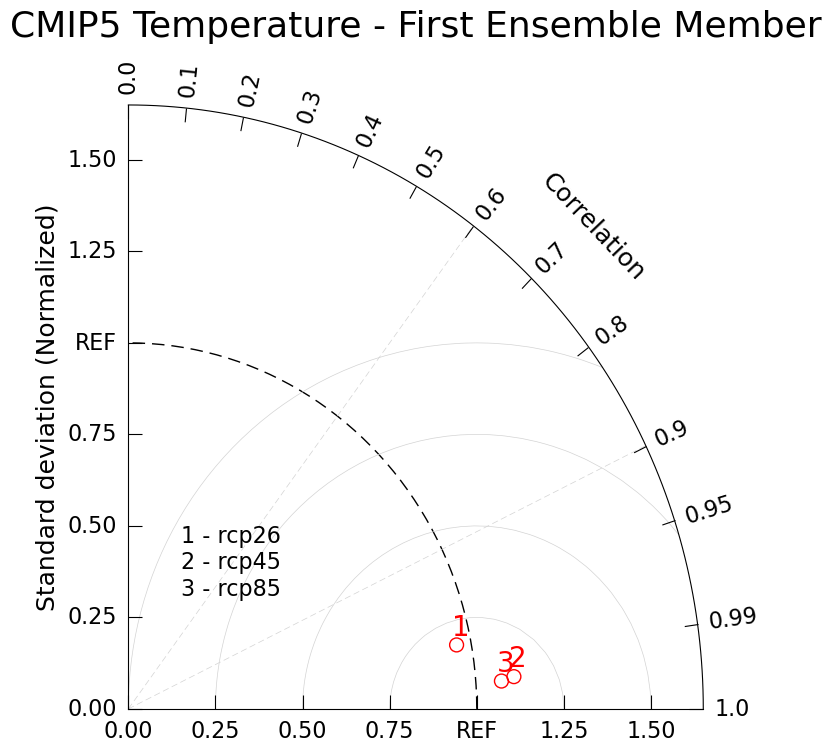

In [105]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(8, 8))
taylor = gv.TaylorDiagram(fig=fig, label='REF')
ax = plt.gca()

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add model sets for p and t datasets
taylor.add_model_set(
    temp_std,
    temp_corr,
    fontsize=20,
    xytext=(-5, 10),  # marker label location, in pixels
    color='red',
    marker='o',
    facecolors='none',
    s=100)  # marker size

#gv.util.set_axes_limits_and_ticks(ax, xlim=[0,2])

namearr = ['rcp26', 'rcp45', 'rcp85']
taylor.add_model_name(namearr, fontsize=16)

# Add figure title
plt.title("CMIP5 Temperature - First Ensemble Member", size=26, pad=45)

# Add Add constant centered RMS difference contours.
taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5);

---

## Summary

### What's next?


## Resources and references

- [Karl E. Taylor - "Summarizing multiple aspects of model performance in a single diagram", AGU 2001](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2000JD900719)
- [Plotting with GeoCAT Tutorial](https://github.com/anissa111/plotting-with-geocat-tutorial/blob/main/notebooks/02-geocat-viz.ipyn)
- [NCL Graphics: Taylor Diagrams](https://www.ncl.ucar.edu/Applications/taylor.shtml)